Loading the necessary tensorflow and plotting library files

In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

The MNIST (Modified National Institute of Standards and Technology database) dataset is a widely used benchmark in the field of machine learning. It consists of a training set of 60,000 images and a test set of 10,000 images, each of which contains a handwritten digit. The images have been preprocessed to be size-normalized and centered in a fixed size of 28×28 pixels, making it easy for data scientists to use the dataset without having to spend a lot of time on preprocessing or formatting.

The MNIST dataset is a popular choice for researchers and practitioners in the field of pattern recognition and machine learning, as it provides a simple yet realistic dataset for testing and comparing different techniques. It has been used in a wide range of applications, including image recognition, computer vision, and deep learning. Its accessibility and versatility have made it a valuable resource for the community, and many researchers continue to build upon the dataset to develop more advanced algorithms and models.

Loading the dataset

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


To visualize the natural handwritten nature of the images in the dataset, a plot of the first nine images is created. This plot provides a glimpse of the variability and complexity of the handwriting styles, which pose a challenge for machine learning algorithms that aim to accurately classify the digits.

The plot typically displays the images in a 3x3 grid, with each image represented by a grayscale image of size 28x28 pixels. The digits are arranged in ascending order, from 0 to 8, and are accompanied by their corresponding labels. This allows the viewer to see the subtle differences between the digits, such as the shape of the loops and the curvature of the lines.

The plot of the first nine images in the MNIST dataset serves as a useful tool for understanding the nature of the dataset and the task of digit classification. It highlights the importance of feature extraction and selection in developing effective machine learning algorithms, as well as the need for robust models that can handle the inherent variability of the data.

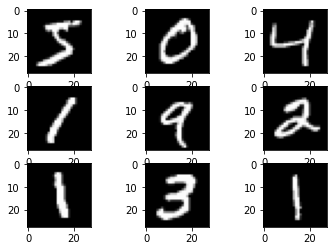

In [3]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [4]:
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainy = to_categorical(trainy)
testy = to_categorical(testy)

Normalizing the input dataset images is very essential. The purpose of normalizing the pixel values is to make the training process more stable and efficient, as it helps to reduce the effect of differences in pixel intensities across images. By scaling the pixel values to the same range, we can ensure that the model is not biased towards certain images based on their brightness or contrast.

The prep_pixels() function takes as input the training and test datasets, which are assumed to be in the form of numpy arrays containing integer values. The function first converts the datasets to float32 format, as this is a common requirement for many machine learning algorithms. It then normalizes the pixel values of the images to be in the range of 0 to 1, by dividing each pixel value by 255.0, which is the maximum value that an integer pixel can take.

In [5]:
def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm

To solve the digit classification problem, we will implement a convolutional neural network (CNN) model. The CNN model will have two main components: the feature extraction front-end, which will consist of convolutional and pooling layers, and the classifier back-end that will make the final prediction.

For the front-end, we will start with a single convolutional layer with a small filter size of 3x3 and a modest number of filters (32), followed by a max-pooling layer. This will allow the model to learn basic features of the digit images such as edges, corners, and curves. The filter maps will then be flattened to provide features to the classifier.

As this is a multi-class classification task, we will require an output layer with 10 nodes to predict the probability distribution of each image belonging to the 10 classes. This will require the use of a softmax activation function. Between the feature extractor and the output layer, we will add a dense layer with 100 nodes to interpret the features learned by the CNN.

All layers will use the rectified linear unit (ReLU) activation function and the He weight initialization scheme, which are both best practices for CNNs.

For the optimizer, we will use stochastic gradient descent (SGD) with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, which is suitable for multi-class classification problems. We will monitor the classification accuracy metric during training, which is appropriate given that we have the same number of examples in each of the 10 classes.

In [6]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
 
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Once the CNN model has been trained and evaluated, we can present the results in two parts: the diagnostic plot of the learning behavior of the model during training and the estimation of the model's performance.

To create the diagnostic plot, we will implement a function called summarize_diagnostics() which takes the collected training histories as input and outputs a plot showing the model's performance on the train and test set during each fold of the k-fold cross-validation. This plot is valuable for getting an idea of whether the model is overfitting, underfitting, or has a good fit for the dataset.

The plot will consist of two subplots, one for loss and one for accuracy. The plot will use blue lines to indicate the model's performance on the training dataset and orange lines to indicate performance on the holdout test dataset.

Below is the code for the summarize_diagnostics() function:

In [7]:
import matplotlib.pyplot as plt

def summarize_diagnostics(histories):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    for i, history in enumerate(histories):
        axs[0].plot(history.history['loss'], color='blue', label='train fold %d' % (i+1))
        axs[0].plot(history.history['val_loss'], color='orange', label='test fold %d' % (i+1))
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()
    
    for i, history in enumerate(histories):
        axs[1].plot(history.history['accuracy'], color='blue', label='train fold %d' % (i+1))
        axs[1].plot(history.history['val_accuracy'], color='orange', label='test fold %d' % (i+1))
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()
    
    plt.show()


The function creates a figure with two subplots, one for loss and one for accuracy, using the subplots() function from the matplotlib.pyplot library. The function then loops over the collected training histories and plots the loss and accuracy values for each fold of the k-fold cross-validation. The set_title(), set_ylabel(), set_xlabel(), and legend() functions are used to add titles, labels, and legends to the plot. Finally, the show() function is called to display the plot.

The summarize_performance() function below implements this for a given list of scores collected during model evaluation.

In [8]:
def summarize_performance(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    plt.boxplot(scores)
    plt.show()

Below is the  code for evaluating the MNSIT dataset after training:

In [9]:
def evaluate_model(X_train, y_train, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainy, testX, testy = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainy, epochs=10, batch_size=32, validation_data=(testX, testy), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testy, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

Test harness for the complete code:

In [10]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # prepare pixel data
    X_train, X_test = prep_pixels(X_train, X_test)
    # prepare labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    # evaluate

In [11]:
trainX, testX = prep_pixels(trainX, testX)

In [12]:
scores, histories = evaluate_model(trainX, trainy)

> 98.575
> 98.725
> 98.600
> 98.858
> 98.692


In [13]:
import numpy as np
print('Accuracy: %.3f%% (%.3f%%)' % (np.mean(scores), np.std(scores)))


Accuracy: 0.987% (0.001%)


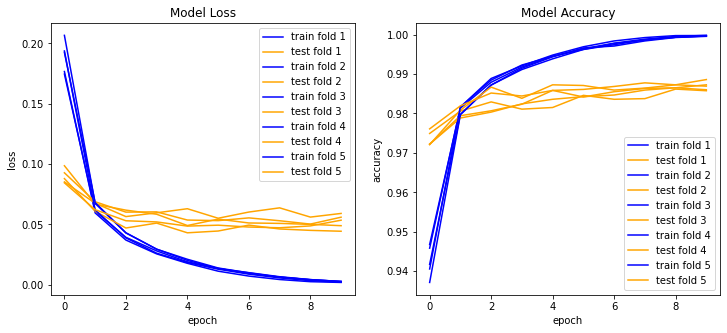

In [14]:
summarize_diagnostics(histories)

To display the test results, you can modify the evaluate_model() function to return the predictions made by the model on the test set. 

In [19]:
def evaluate_model(X_train, y_train, testX, testy, n_folds=2):
    scores, histories, y_pred_classes = list(), list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainy, testX, testy = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainy, epochs=10, batch_size=32, validation_data=(testX, testy), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testy, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
        y_pred = model.predict(testX)
        y_pred_classes.append(np.argmax(y_pred, axis=1))
        
    return scores, histories, y_pred_classes

In [20]:
acc, histories, y_pred_classes = evaluate_model(trainX, trainy, testX, testy)

> 98.287
> 98.533


The y_pred_classes array will contain the predicted class labels for the test set. You can then use this array to compute various metrics, such as the confusion matrix or classification report, to evaluate the performance of the model on the test set. For example:

[5 0 9 2 1 3 4 1 7]


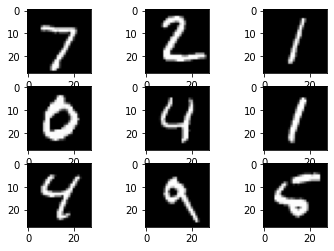

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
print((np.array(y_pred_classes)[1,:9]))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(testX[i], cmap=plt.get_cmap('gray'))
plt.show()

References:

[1] How to Develop a CNN for MNIST Handwritten Digit Classification by Jason Brownlee on May 8, 2019 in Deep Learning for Computer Vision. Link: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/.

[2] Training a neural network on MNIST with Keras. Link: https://www.tensorflow.org/datasets/keras_example